In [8]:
import numpy as np

def recover_verblunsky_coeffs(h11_sequence: list[float]) -> tuple[list[float], float]:
    """
    Recovers the Verblunsky coefficients from a sequence of Hamiltonian values.
    This implements the algorithm described in Section 3 of the paper. [cite: 136]

    Args:
        h11_sequence: A list of positive real numbers {h₁₁ⁿ} from the
                      step-function Hamiltonian. [cite: 132]

    Returns:
        A tuple containing:
        - A list of the Verblunsky coefficients {αₙ}.
        - The scaling factor c₀ = 1/h₁₁⁰, which is the total mass of the measure. [cite: 179]
    """
    if not all(h > 0 for h in h11_sequence):
        raise ValueError("All Hamiltonian values must be positive.") [cite: 132]

    # h_tilde corresponds to the normalized sequence for a probability measure. 
    h0 = h11_sequence[0]
    h_tilde = [h / h0 for h in h11_sequence]
    
    alpha_coeffs = []
    # Iterate up to the second to last element to calculate αₙ for n=0, 1, ...
    for n in range(len(h_tilde) - 1):
        # This is the rearranged version of Equation (4) in the paper. 
        ratio = h_tilde[n+1] / h_tilde[n]
        alpha_n = (1 - ratio) / (1 + ratio)
        alpha_coeffs.append(alpha_n)
        
    c0 = 1.0 / h0
    
    print(f"Algorithm 1: Recovered Verblunsky coefficients (α_n).")
    print(f"Total mass of the measure (c₀): {c0:.4f}")
    
    return alpha_coeffs, c0



import numpy as np
from scipy.linalg import toeplitz, inv
from scipy.integrate import quad

def recover_verblunsky_coeffs(h11_sequence: list[float]) -> tuple[list[float], float]:
    """
    Recovers the Verblunsky coefficients from a sequence of Hamiltonian values.
    This implements the algorithm described in Section 3 of the paper.

    Args:
        h11_sequence: A list of positive real numbers {h₁₁ⁿ} from the
                      step-function Hamiltonian.

    Returns:
        A tuple containing:
        - A list of the Verblunsky coefficients {αₙ}.
        - The scaling factor c₀ = 1/h₁₁⁰, which is the total mass of the measure.
    """
    if not all(h > 0 for h in h11_sequence):
        raise ValueError("All Hamiltonian values must be positive.")
    h0 = h11_sequence[0]
    h_tilde = [h / h0 for h in h11_sequence]
    alpha_coeffs = []
    for n in range(len(h_tilde) - 1):
        ratio = h_tilde[n+1] / h_tilde[n]
        alpha_n = (1 - ratio) / (1 + ratio)
        alpha_coeffs.append(alpha_n)
    c0 = 1.0 / h0
    print(f"Algorithm 1: Recovered Verblunsky coefficients (α_n).")
    print(f"Total mass of the measure (c₀): {c0:.4f}")
    return alpha_coeffs, c0
    
# ----------------- CORRECTED FUNCTION BELOW -----------------

def recover_moments(h11_sequence: list[float], num_moments: int) -> list[float]:
    """
    Recovers the moments of the spectral measure from Hamiltonian values.
    This is the CORRECTED implementation of the algorithm from Section 4.

    Args:
        h11_sequence: A list of positive real numbers {h₁₁ⁿ}.
        num_moments: The total number of moments to recover (e.g., for c₀ to cₙ, this is n+1).

    Returns:
        A list of the recovered moments {cₙ}.
    """
    if len(h11_sequence) < num_moments:
        raise ValueError("Length of h11_sequence must be at least num_moments.")

    h0 = h11_sequence[0]
    h_tilde = [h / h0 for h in h11_sequence]
    moments_tilde = []

    moments_tilde.append(1.0) # c₀_tilde is always 1
    if num_moments == 1: return [m / h0 for m in moments_tilde]

    c1_tilde = (1 - h_tilde[1]) / (1 + h_tilde[1])
    moments_tilde.append(c1_tilde)
    if num_moments == 2: return [m / h0 for m in moments_tilde]

    # Iteratively solve for c₂, c₃, ...
    # To find c_(n+1), we use moments {c₀, ..., cₙ}.
    for n in range(1, num_moments - 1):
        # We have c₀, ..., cₙ and need to find c_(n+1).
        # The formula in Remark 4.4 requires J_(n-1), which is an n x n matrix.
        
        # Construct J_(n-1) from {c₀, ..., c_(n-1)}
        J_n_minus_1 = toeplitz(moments_tilde[:n])
        J_n_minus_1_inv = inv(J_n_minus_1)
        
        # Construct vectors uₙ and vₙ from {c₁, ..., cₙ}
        u_n = np.array(moments_tilde[1:n+1]).reshape(-1, 1)
        v_n = np.flip(u_n).reshape(-1, 1)
        K = np.ones((n, 1))

        # Calculate Δₙ and Dₙ per Remark 4.4.
        delta_n = 1 - u_n.T @ J_n_minus_1_inv @ u_n
        D_n = u_n.T @ J_n_minus_1_inv @ v_n
        
        # Apply Equation (13) to solve for c_(n+1)
        term1 = (1 + D_n / delta_n) * (1 - K.T @ J_n_minus_1_inv @ u_n)**2
        term2 = (delta_n - D_n) * h_tilde[n+1]
        numerator = term1 - term2
        
        denom_term1 = h_tilde[n+1] * delta_n
        denom_term2 = (1 - K.T @ J_n_minus_1_inv @ u_n)**2 / delta_n
        denominator = denom_term1 + denom_term2
        
        # Handle potential division by zero if denominator is negligible
        if np.isclose(denominator, 0):
             c_n_plus_1_tilde = 0.0
        else:
             c_n_plus_1_tilde = (numerator / denominator).item()

        moments_tilde.append(c_n_plus_1_tilde)
        
    final_moments = [m / h0 for m in moments_tilde]
    print(f"\nAlgorithm 2 (Corrected): Recovered moments (c_n).")
    return final_moments

# -----------------------------------------------------------

def approximate_hamiltonian(h_func: callable, T: float, num_steps: int) -> list[float]:
    h11_sequence = []
    for n in range(num_steps):
        integral, _ = quad(h_func, n * T, (n + 1) * T)
        h11_sequence.append(integral / T)
    return h11_sequence

In [2]:
from scipy.integrate import quad

def approximate_hamiltonian(h_func: callable, T: float, num_steps: int) -> list[float]:
    """
    Approximates a continuous Hamiltonian with a step function by averaging.
    This implements the 'periodization' method from Section 5. [cite: 291]
    
    Args:
        h_func: A callable function representing h₁₁(t).
        T: The step size (length of the interval).
        num_steps: The number of steps to approximate.

    Returns:
        A list of the averaged Hamiltonian values {h₁₁^(T,n)}.
    """
    h11_sequence = []
    for n in range(num_steps):
        # Integrate h₁₁(s) from nT to (n+1)T. 
        integral, _ = quad(h_func, n * T, (n + 1) * T)
        h11_sequence.append(integral / T)
    return h11_sequence

Generated 20 coefficients for a square wave.


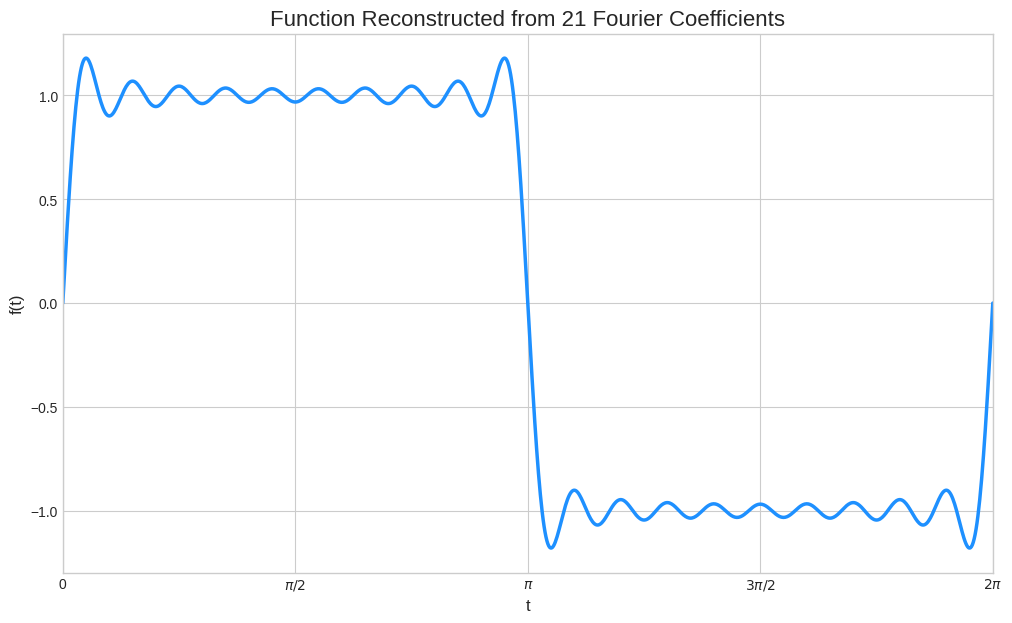

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fourier_series(coeffs: list[complex]):
    """
    Reconstructs and plots a function from its Fourier series coefficients.

    The function is plotted on the interval [0, 2*pi]. This implementation
    assumes the reconstructed function is real, which implies that the
    Fourier coefficients for negative indices are the complex conjugates
    of the coefficients for positive indices (c_{-n} = conj(c_n)).

    Args:
        coeffs (list[complex]): A list or NumPy array of complex Fourier
                                coefficients in the order [c0, c1, c2, ..., cN].
    """
    # Number of coefficients for positive frequencies
    N = len(coeffs) - 1
    
    # Create 1000 points for t in the interval [0, 2*pi] for a smooth plot
    t = np.linspace(0, 2 * np.pi, 1000)
    
    # Start with the c0 term (the DC offset), which is constant
    # Convert coeffs to a numpy array for easier handling
    coeffs = np.array(coeffs)
    y = np.full(t.shape, coeffs[0], dtype=complex)
    
    # Sum the remaining terms for n = 1, 2, ..., N
    for n in range(1, N + 1):
        # Get the coefficient c_n
        cn = coeffs[n]
        # Add the positive frequency term (c_n * e^(i*n*t))
        # and the negative frequency term (c_{-n} * e^(-i*n*t))
        # where c_{-n} is the conjugate of c_n
        term = cn * np.exp(1j * n * t) + np.conj(cn) * np.exp(-1j * n * t)
        y += term
        
    # The resulting function should be real-valued. We take np.real
    # to discard any small imaginary parts from floating-point errors.
    y = np.real(y)
    
    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    plt.plot(t, y, color='dodgerblue', linewidth=2.5)
    
    # Set plot titles and labels
    plt.title(f'Function Reconstructed from {N+1} Fourier Coefficients', fontsize=16)
    plt.xlabel('t', fontsize=12)
    plt.ylabel('f(t)', fontsize=12)
    
    # Set plot limits and ticks for clarity on the [0, 2*pi] interval
    plt.xlim(0, 2 * np.pi)
    plt.xticks(
        [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
        ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
    )
    plt.grid(True)
    plt.show()

# --- Example Usage ---
if __name__ == '__main__':
    # Let's generate the Fourier coefficients for a square wave
    # f(t) = 1 for 0 < t < pi, and -1 for pi < t < 2*pi
    # The coefficients are: c0 = 0 and c_n = -2i / (n*pi) for odd n, 0 for even n.
    
    N_TERMS = 20  # Number of terms (c1 to c20) to use in the approximation
    
    # Initialize list with c0
    square_wave_coeffs = [0.0 + 0.0j]
    
    # Calculate and add c1, c2, ..., cN
    for n in range(1, N_TERMS + 1):
        if n % 2 != 0:  # n is odd
            cn = -2j / (n * np.pi)
            square_wave_coeffs.append(cn)
        else:  # n is even
            square_wave_coeffs.append(0.0 + 0.0j)
            
    print(f"Generated {len(square_wave_coeffs) - 1} coefficients for a square wave.")
    
    # Call the function to plot the reconstructed square wave
    plot_fourier_series(square_wave_coeffs)

--- Running Example 6.1 from the paper ---
Input Hamiltonian sequence h₁₁ⁿ: ['1.0', '3.0', '6.0', '10.0', '15.0', '21.0', '28.0', '36.0', '45.0', '55.0', '66.0', '78.0', '91.0', '105.0', '120.0', '136.0', '153.0', '171.0', '190.0', '210.0', '231.0', '253.0', '276.0', '300.0', '325.0', '351.0', '378.0', '406.0', '435.0', '465.0', '496.0', '528.0', '561.0', '595.0', '630.0', '666.0', '703.0', '741.0', '780.0', '820.0', '861.0', '903.0', '946.0', '990.0', '1035.0', '1081.0', '1128.0', '1176.0', '1225.0', '1275.0', '1326.0', '1378.0', '1431.0', '1485.0', '1540.0', '1596.0', '1653.0', '1711.0', '1770.0', '1830.0', '1891.0', '1953.0', '2016.0', '2080.0', '2145.0', '2211.0', '2278.0', '2346.0', '2415.0', '2485.0', '2556.0', '2628.0', '2701.0', '2775.0', '2850.0', '2926.0', '3003.0', '3081.0', '3160.0', '3240.0', '3321.0', '3403.0', '3486.0', '3570.0', '3655.0', '3741.0', '3828.0', '3916.0', '4005.0', '4095.0', '4186.0', '4278.0', '4371.0', '4465.0', '4560.0', '4656.0', '4753.0', '4851.0', '49

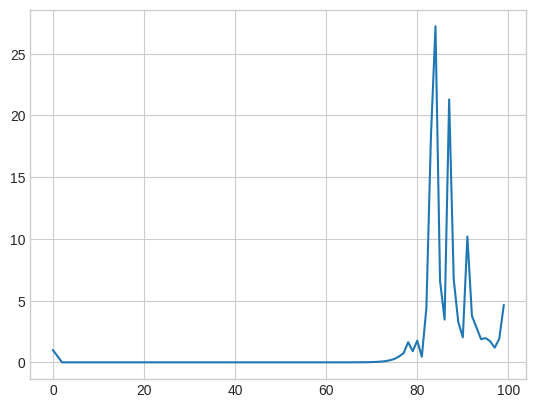

In [10]:
if __name__ == "__main__":
    print("--- Running Example 6.1 from the paper ---") 
    
    # Define the Hamiltonian sequence from Example 6.1
    num_terms = 100
    h11_seq = [(n + 1) * (n + 2) / 2 for n in range(num_terms + 1)]
    #h11_seq = [2**n for n in range(num_terms + 1)]
    print(f"Input Hamiltonian sequence h₁₁ⁿ: {[f'{val:.1f}' for val in h11_seq]}")
    
    # --- Test Algorithm 1: Verblunsky Coefficients ---
    alpha_coeffs, c0 = recover_verblunsky_coeffs(h11_seq)
    
    # Expected values for αₙ
    expected_alphas = [-1 / (n + 2) for n in range(num_terms)]
    
    print("n | Recovered αₙ | Expected αₙ")
    print("-" * 30)
    for n in range(len(alpha_coeffs)):
        print(f"{n} | {alpha_coeffs[n]:12.4f} | {expected_alphas[n]:12.4f}")
        
    # --- Test Algorithm 2: Moments ---
    moments = recover_moments(h11_seq, num_moments=num_terms)

    print(f"\nRecovered moments cₙ: {[f'{m:.4f}' for m in moments]}")
    
    # Expected values for cₙ
    expected_moments = [1.0, -0.5] + [0.0] * (num_terms - 2)
    
    print("n | Recovered cₙ | Expected cₙ")
    print("-" * 30)
    for n in range(len(moments)):
        print(f"{n} | {moments[n]:12.4f} | {expected_moments[n]:12.4f}")

    plt.plot([abs(z) for z in moments])
        
    print("\n--- Running Example with Non-Step-Function Hamiltonian (h₁₁(t) = 1+t) ---")
    
    # Define the continuous Hamiltonian function
    h11_continuous = lambda t: 1 + t
    
    # Approximate it with a step function
    T = 0.1  # A small step size
    num_approximated_steps = 10
    approximated_h11 = approximate_hamiltonian(h11_continuous, T, num_approximated_steps)
    print(f"Approximated h₁₁ⁿ for T={T}: {[f'{h:.2f}' for h in approximated_h11]}")
    
    # Now, find its spectral properties using the implemented algorithms
    approx_alphas, approx_c0 = recover_verblunsky_coeffs(approximated_h11)
    print("First 5 Verblunsky coefficients of the approximation:")
    for n in range(5):
        print(f"α_{n} ≈ {approx_alphas[n]:.4f}")

Algorithm 1: Recovered Verblunsky coefficients (α_n).
Total mass of the measure (c₀): 1.0000

Recovered Verblunsky coefficients αₙ: ['0.0000', '-0.3333', '-0.2000', '-0.2500', '-0.2308', '-0.2381', '-0.2353', '-0.2364', '-0.2360', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361', '-0.2361',

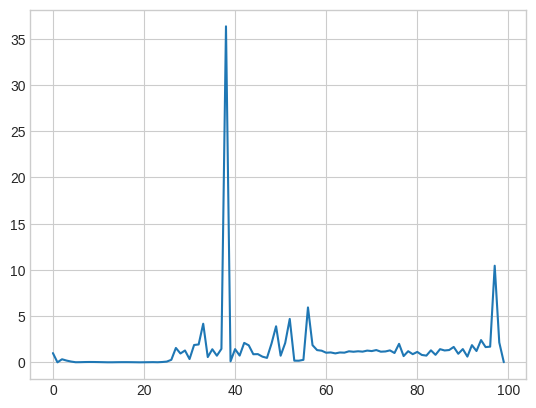

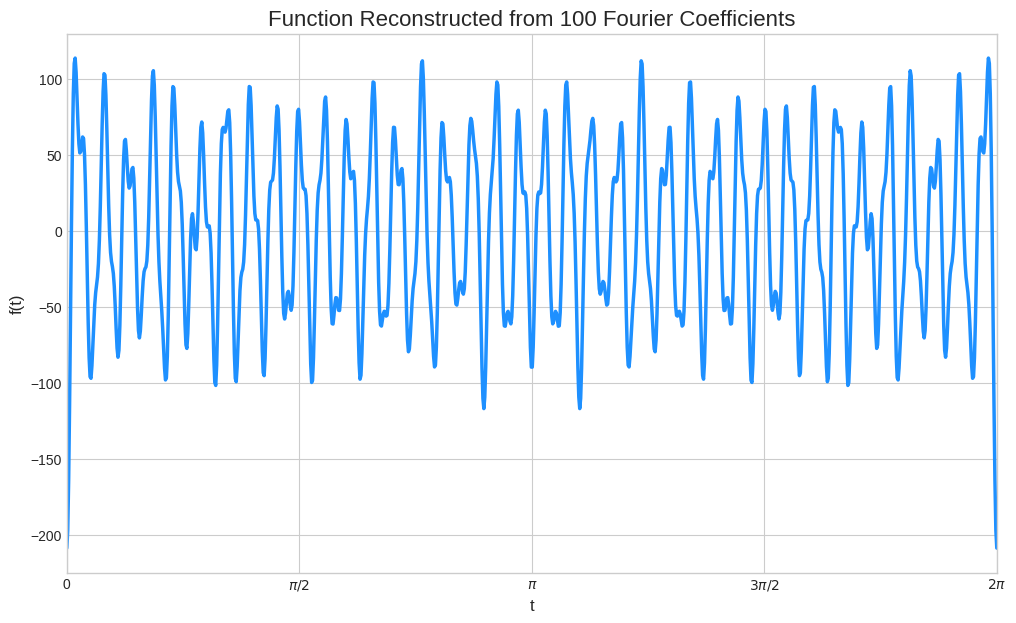

In [17]:
num_terms = 100
fibo = [1, 1]
for i in range(num_terms-2):
    fibo.append(fibo[-1] + fibo[-2])
#fibo = [(n + 1) * (n + 2) / 2 for n in range(num_terms)]
#fibo = [1+4*n**2 for n in range(num_terms)]
alpha_coeffs, c0 = recover_verblunsky_coeffs(fibo)
print(f"\nRecovered Verblunsky coefficients αₙ: {[f'{a:.4f}' for a in alpha_coeffs]}")
moments = recover_moments(fibo, num_moments=num_terms)
plt.plot([abs(z) for z in moments])
print(f"\nRecovered moments cₙ: {[f'{m:.4f}' for m in moments]}")
plot_fourier_series(moments)

--- Verifying recursive implementation with Example 6.1 ---
Input Hamiltonian sequence h₁₁ⁿ: ['1.0', '3.0', '6.0', '10.0', '15.0', '21.0', '28.0', '36.0', '45.0', '55.0', '66.0', '78.0', '91.0', '105.0', '120.0', '136.0', '153.0', '171.0', '190.0', '210.0', '231.0', '253.0', '276.0', '300.0', '325.0', '351.0', '378.0', '406.0', '435.0', '465.0', '496.0', '528.0', '561.0', '595.0', '630.0', '666.0', '703.0', '741.0', '780.0', '820.0', '861.0', '903.0', '946.0', '990.0', '1035.0', '1081.0', '1128.0', '1176.0', '1225.0', '1275.0', '1326.0', '1378.0', '1431.0', '1485.0', '1540.0', '1596.0', '1653.0', '1711.0', '1770.0', '1830.0', '1891.0', '1953.0', '2016.0', '2080.0', '2145.0', '2211.0', '2278.0', '2346.0', '2415.0', '2485.0', '2556.0', '2628.0', '2701.0', '2775.0', '2850.0', '2926.0', '3003.0', '3081.0', '3160.0', '3240.0', '3321.0', '3403.0', '3486.0', '3570.0', '3655.0', '3741.0', '3828.0', '3916.0', '4005.0', '4095.0', '4186.0', '4278.0', '4371.0', '4465.0', '4560.0', '4656.0', '4753.

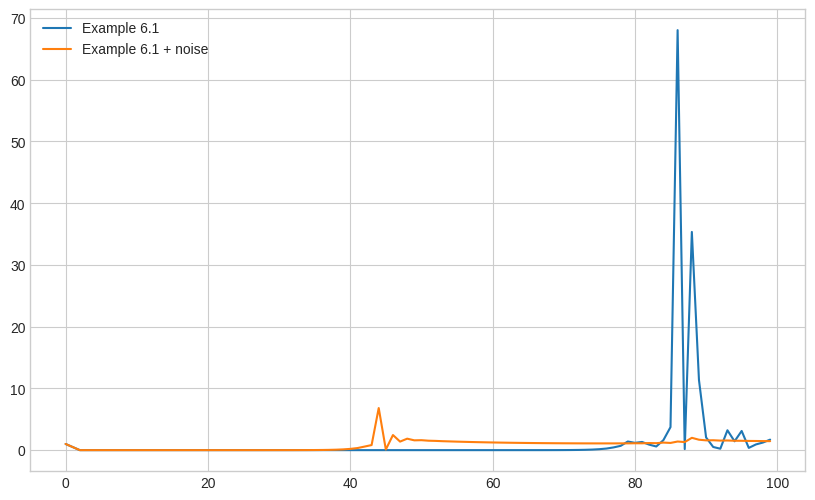

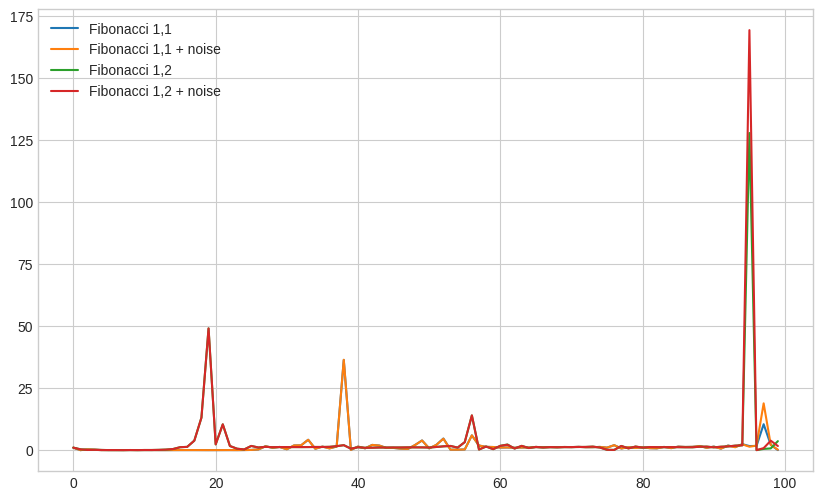

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.integrate import quad
import random

def recover_moments_recursive_inverse(h11_sequence: list[float], num_moments: int) -> list[float]:
    """
    Recovers moments using the recursive inverse update from Theorem 4.3.
    This is a more efficient and stable implementation of the Section 4 algorithm.

    Args:
        h11_sequence: A list of positive real numbers {h₁₁ⁿ}.
        num_moments: The total number of moments to recover.

    Returns:
        A list of the recovered moments {cₙ}.
    """
    if len(h11_sequence) < num_moments:
        raise ValueError("Length of h11_sequence must be at least num_moments.")

    h0 = h11_sequence[0]
    h_tilde = [h / h0 for h in h11_sequence]
    moments_tilde = []

    # Base cases
    c0_tilde = 1.0
    moments_tilde.append(c0_tilde)
    if num_moments == 1: return [m / h0 for m in moments_tilde]

    c1_tilde = (1 - h_tilde[1]) / (1 + h_tilde[1])
    moments_tilde.append(c1_tilde)
    if num_moments == 2: return [m / h0 for m in moments_tilde]
    
    # Initialize the recursion with J₀⁻¹
    J_inv = np.array([[1.0 / c0_tilde]]) # J₀⁻¹ is the 1x1 matrix [1/c₀]

    # Iteratively solve for c₂, c₃, ...
    for n in range(1, num_moments - 1):
        # At this step, we have moments c₀,...,cₙ and J_(n-1)⁻¹
        # We will now solve for c_(n+1)

        J_n_minus_1_inv = J_inv
        u_n = np.array(moments_tilde[1:n+1]).reshape(-1, 1)
        v_n = np.flip(u_n).reshape(-1, 1)
        K = np.ones((n, 1))

        # Calculate Δₙ and Dₙ using the available J_(n-1)⁻¹
        delta_n = 1 - u_n.T @ J_n_minus_1_inv @ u_n
        D_n = u_n.T @ J_n_minus_1_inv @ v_n
        
        # Apply Equation (13) to solve for c_(n+1)
        term1 = (1 + D_n / delta_n) * (1 - K.T @ J_n_minus_1_inv @ u_n)**2
        term2 = (delta_n - D_n) * h_tilde[n+1]
        numerator = term1 - term2
        denom_term1 = h_tilde[n+1] * delta_n
        denom_term2 = (1 - K.T @ J_n_minus_1_inv @ u_n)**2 / delta_n
        denominator = denom_term1 + denom_term2
        
        c_n_plus_1_tilde = (numerator / denominator).item()
        moments_tilde.append(c_n_plus_1_tilde)

        # --- RECURSIVE INVERSE UPDATE ---
        # Now, calculate Jₙ⁻¹ from J_(n-1)⁻¹ to prepare for the next iteration
        # using the formula from Theorem 4.3 (Equation 11) [cite: 251]
        delta_n_inv = 1.0 / delta_n
        
        # Define the component vectors and matrices for the block formula
        J_inv_u = J_n_minus_1_inv @ u_n
        
        # Top-left scalar
        top_left = delta_n_inv
        
        # Top-right row vector
        top_right = -delta_n_inv * J_inv_u.T
        
        # Bottom-left column vector
        bottom_left = -delta_n_inv * J_inv_u
        
        # Bottom-right block matrix
        bottom_right = J_n_minus_1_inv + delta_n_inv * (J_inv_u @ J_inv_u.T)

        # Assemble the new inverse Jₙ⁻¹
        new_J_inv = np.block([
            [top_left, top_right],
            [bottom_left, bottom_right]
        ])
        J_inv = new_J_inv
        
    final_moments = [m / h0 for m in moments_tilde]
    print(f"\nAlgorithm 2 (Recursive Inverse): Recovered moments (c_n).")
    return final_moments

# --- Verification ---
if __name__ == "__main__":
    plt.figure(figsize=(10, 6))
    print("--- Verifying recursive implementation with Example 6.1 ---")
    num_terms = 100
    h11_seq = [(n + 1) * (n + 2) / 2 for n in range(num_terms + 1)]
    print(f"Input Hamiltonian sequence h₁₁ⁿ: {[f'{val:.1f}' for val in h11_seq]}")

    moments = recover_moments_recursive_inverse(h11_seq, num_moments=num_terms)

    plt.plot([abs(z) for z in moments], label="Example 6.1")
    
    h11_seq = [x + 1e-8*random.random() for x in h11_seq]
    moments = recover_moments_recursive_inverse(h11_seq, num_moments=num_terms)
    plt.plot([abs(z) for z in moments], label="Example 6.1 + noise")

    plt.legend()

    expected_moments = [1.0, -0.5] + [0.0] * (num_terms - 2)
    
    # print("n | Recovered cₙ | Expected cₙ")
    # print("-" * 30)
    # for n in range(len(moments)):
    #     print(f"{n} | {moments[n]:12.4f} | {expected_moments[n]:12.4f}")

    #plt.plot([abs(z) for z in moments])

    plt.figure(figsize=(10, 6))

    fibo = [1, 1]
    for i in range(num_terms-2):
        fibo.append(fibo[-1] + fibo[-2])
    moments = recover_moments_recursive_inverse(fibo, num_moments=num_terms)
    fig1 = plt.plot([abs(z) for z in moments], label="Fibonacci 1,1")
    fibo = [x+1e-8*random.random() for x in fibo]
    moments = recover_moments_recursive_inverse(fibo, num_moments=num_terms)
    plt.plot([abs(z) for z in moments], label="Fibonacci 1,1 + noise")

    fibo = [1, 2]
    for i in range(num_terms-2):
        fibo.append(fibo[-1] + fibo[-2])
    moments = recover_moments_recursive_inverse(fibo, num_moments=num_terms)
    plt.plot([abs(z) for z in moments], label="Fibonacci 1,2")
    fibo = [x+1e-8*random.random() for x in fibo]
    moments = recover_moments_recursive_inverse(fibo, num_moments=num_terms)
    plt.plot([abs(z) for z in moments], label="Fibonacci 1,2 + noise")
    plt.legend()